<a href="https://colab.research.google.com/github/kevin7548/WCDL/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/WCDL')

Mounted at /content/drive


In [ ]:
!pip install cartopy xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 96.4 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import cartopy.crs as ccrs
import seaborn as sns

In [ ]:
# Define time and coordinates
train_time = pd.date_range(start='1/1/1979', end='12/1/2014', freq='MS')
test_time = pd.date_range(start='1/1/2015', end='12/1/2023', freq='MS')
all_time = pd.date_range(start='1/1/1979', end='12/1/2023', freq='MS')

#lon = np.linspace(-180, 177.5, 144)
#lat = np.linspace(90.0, -90.0, 73)
lon = np.linspace(-180, 180, 241)
lat = np.linspace(-90, 90, 121)

# Load data

## 1. ERA5 Reanalysis

In [ ]:
ds1 = xr.open_dataset('data_0.nc')
ds1_coarse = ds1.interp(latitude=lat, longitude=lon)
ds1_coarse = ds1_coarse.rename({'msl': 'mslp', 'siconc': 'icec'})

ds2 = xr.open_dataset('data_1.nc')
ds2_coarse = ds2.interp(latitude=lat, longitude=lon)
ds2_coarse = ds2_coarse.rename({'mtnlwrf': 'mtnlwr'})
ds2_coarse = ds2_coarse.assign_coords(valid_time=ds1_coarse.valid_time)

ds_merged = xr.merge([ds1_coarse, ds2_coarse])
ds_merged.to_netcdf('modified_data_0.nc')

In [ ]:
ds3 = xr.open_dataset('data_2.nc', chunks={'time': 1})
ds3_coarse = ds3.interp(latitude=lat, longitude=lon)

ds3_coarse.to_netcdf('modified_data_1.nc')

In [ ]:
modified_data_0 = xr.open_dataset('modified_data_0.nc')
modified_data_1 = xr.open_dataset('modified_data_1.nc')

ds = xr.merge([modified_data_0, modified_data_1])
ds.to_netcdf('modified_data.nc')

In [ ]:
ds = xr.open_dataset('modified_data.nc')
ds

<xarray.Dataset> Size: 504MB
Dimensions:     (valid_time: 540, latitude: 121, longitude: 241)
Coordinates:
    expver      (valid_time) object 4kB ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2023-12-01
  * longitude   (longitude) float64 2kB -180.0 -178.5 -177.0 ... 178.5 180.0
  * latitude    (latitude) float64 968B -90.0 -88.5 -87.0 ... 87.0 88.5 90.0
    number      int32 4B ...
Data variables:
    icec        (valid_time, latitude, longitude) float64 126MB ...
    mslp        (valid_time, latitude, longitude) float64 126MB ...
    mtnlwr      (valid_time, latitude, longitude) float64 126MB ...
    t2m         (valid_time, latitude, longitude) float32 63MB ...
    snowc       (valid_time, latitude, longitude) float32 63MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

## 2. Climate Indices

In [ ]:
# Store file names in lists
clmidx_names = ['aao', 'ammsst', 'amon.us.long', 'ao',
                'ea', 'espi', 'gmsst', 'meiv2', 'nao',
                'nina1.anom', 'nina3.anom', 'nina4.anom', 'nina34.anom',
                'oni', 'pacwarm', 'pna', 'qbo', 'soi', 'solar',
                'tna', 'tsa', 'whwp', 'wp'] # epo 일단 제외
data_array = []

# Load and process data for each climate index
for name in clmidx_names:
    dt = pd.read_csv(
        f"{name}.data", # Read data file
        header=None, sep='\s+', skiprows=1, # Ignore header and use whitespace as separator
        index_col=0, on_bad_lines='skip' # Set the first column as index, skip problematic lines
    ).loc['1979':'2023'].copy() # Select data from 1979 to 2023

    # Flatten and convert -99.99 to NaN
    dt = dt.replace([-99.99, -99.9, -9.99, -999], np.nan)

    dt = dt.interpolate(method='linear', axis=0)

    dt = dt.fillna(method='ffill')
    dt = dt.fillna(method='bfill')

    # Convert to an xarray DataArray
    data_array.append(
        xr.DataArray(
            dt.values.flatten().astype(float), # Flatten the values and ensure float type
            coords={'time':all_time}, # Assign time coordinates
            dims='time', # Define time as the dimension
            name=name # Set the variable name
        )
    )

#    if name == 'epo':
#      for i in range(len(dt)):
#        if dt.iloc[i] == np.nan:
#          dt.iloc[i] = (dt.iloc[i-1]+dt.iloc[i+1])/2
#      dt.iloc[len(dt)] = dt.iloc[len(dt)-1]*2 - dt.iloc[len(dt)-2]

# Create an xarray Dataset
df = xr.Dataset(
    data_vars={name: da for name, da in zip(clmidx_names, data_array)},
    coords={'time': all_time}, # Set time coordinates
    attrs={'name': 'Climate Indices'} # Add metadata
    )

print(df)
df.to_netcdf('clm_idx.nc')

<ipython-input-25-e1cde45a5d4c>:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dt = dt.interpolate(method='linear', axis=0)
<ipython-input-25-e1cde45a5d4c>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dt = dt.fillna(method='ffill')
<ipython-input-25-e1cde45a5d4c>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dt = dt.fillna(method='bfill')
<ipython-input-25-e1cde45a5d4c>:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dt = dt.interpolate(method='linear', axis=0)
<ipython-input-25-e1cde45a5d4c>:22: FutureWarning: DataFrame.fillna with 'method' is

<xarray.Dataset> Size: 104kB
Dimensions:       (time: 540)
Coordinates:
  * time          (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01
Data variables: (12/23)
    aao           (time) float64 4kB 0.209 0.356 0.899 ... 0.535 0.097 1.51
    ammsst        (time) float64 4kB 1.15 2.5 2.37 2.16 ... 5.72 5.51 4.0 2.58
    amon.us.long  (time) float64 4kB -0.205 -0.164 -0.241 ... 0.483 0.282 0.218
    ao            (time) float64 4kB -2.233 -0.697 -0.814 ... -0.036 -0.222
    ea            (time) float64 4kB -0.79 -0.2 -0.1 0.15 ... 0.61 0.13 0.08
    espi          (time) float64 4kB 1.015 0.705 0.1729 ... 1.312 -0.7904 -1.25
    ...            ...
    soi           (time) float64 4kB -0.7 1.6 0.2 -0.2 ... -2.1 -0.8 -1.3 -0.4
    solar         (time) float64 4kB 2.03e+03 2.041e+03 ... 1.544e+03 1.593e+03
    tna           (time) float64 4kB 0.17 0.28 0.15 0.29 ... 1.43 1.32 1.09 1.17
    tsa           (time) float64 4kB -0.16 -0.24 -0.31 0.01 ... 0.41 0.91 1.31
    whwp     

<ipython-input-25-e1cde45a5d4c>:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  dt = dt.interpolate(method='linear', axis=0)
<ipython-input-25-e1cde45a5d4c>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dt = dt.fillna(method='ffill')
<ipython-input-25-e1cde45a5d4c>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dt = dt.fillna(method='bfill')
<ipython-input-25-e1cde45a5d4c>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dt = dt.fillna(method='ffill')
<ipython-input-25-e1cde45a5d4c>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. 

## 3. Korea Temperature

In [ ]:
korea_temp = xr.open_dataset('korea_temp.nc')
korea_mean_temp = korea_temp['t2m'].mean(dim=['latitude', 'longitude']).sel(valid_time=all_time)
korea_mean_temp
#korea_mean_temp.to_netcdf('korea_mean_temp.nc')

<xarray.DataArray 't2m' (valid_time: 540)> Size: 2kB
array([273.1578 , 273.6553 , 277.5164 , 281.7323 , 287.239  , 292.26657,
       295.06052, 296.71243, 292.23358, 287.9658 , 279.43958, 275.48828,
       270.191  , 271.0583 , 277.0113 , 281.39816, 287.75604, 292.22787,
       294.45538, 294.89944, 291.47195, 285.8574 , 281.72165, 271.04385,
       268.30115, 271.91757, 277.29697, 282.83337, 286.77142, 291.3167 ,
       296.46954, 296.2108 , 291.86517, 286.0302 , 277.27914, 274.06665,
       270.36874, 272.8986 , 277.7458 , 282.79706, 288.00406, 291.8295 ,
       295.21054, 296.90326, 292.1001 , 287.68143, 281.19742, 273.8628 ,
       272.08905, 271.65555, 277.4889 , 283.91464, 287.93115, 291.3232 ,
       294.68   , 297.2533 , 293.84586, 286.75568, 279.97232, 273.2522 ,
       269.12863, 270.20038, 274.89542, 281.89865, 287.57455, 292.49246,
       296.118  , 297.6851 , 292.40506, 286.19852, 280.92075, 273.30264,
       268.86136, 272.7046 , 276.379  , 282.7847 , 287.97412, 291.74957,
       296.38068, 297.6007 , 293.04678, 287.4657 , 279.25278, 271.0169 ,
       269.1246 , 270.43686, 276.92047, 282.30753, 287.16913, 291.628  ,
       294.24258, 296.14633, 291.64908, 285.3708 , 279.2981 , 275.20602,
       270.96573, 272.87704, 276.11905, 282.13553, 287.44534, 292.02164,
       295.33752, 295.8515 , 291.94394, 287.7079 , 279.99353, 274.83383,
       272.3481 , 271.52194, 276.14148, 282.5282 , 287.6502 , 292.4136 ,
       295.5472 , 297.26105, 293.1191 , 287.45578, 279.32025, 274.20557,
...
       296.61115, 296.1984 , 293.10092, 287.87656, 281.83084, 272.13956,
       272.5937 , 273.86572, 277.86508, 283.36978, 288.65692, 292.30856,
       295.6787 , 297.02902, 293.0483 , 287.37796, 281.40784, 275.70334,
       270.88968, 273.30457, 278.62457, 284.0373 , 288.81216, 292.8731 ,
       296.54877, 298.26178, 293.67072, 287.7386 , 280.1953 , 275.6733 ,
       272.4687 , 273.8626 , 278.30118, 284.5173 , 289.0814 , 292.49954,
       297.7775 , 297.38797, 293.47073, 287.65915, 279.5189 , 272.7002 ,
       270.33066, 271.63455, 278.71155, 283.83817, 288.11783, 292.84235,
       297.6579 , 298.42844, 293.1867 , 286.78235, 281.5133 , 274.07977,
       273.22842, 274.50085, 279.34256, 283.31647, 289.3453 , 292.3038 ,
       296.3437 , 297.73828, 294.23495, 288.57632, 281.21512, 275.47153,
       274.64587, 275.54028, 279.4478 , 282.5541 , 288.2997 , 293.45966,
       295.1444 , 297.944  , 292.96387, 287.0742 , 281.61075, 273.7997 ,
       271.53488, 274.99203, 279.9785 , 284.21365, 288.17078, 292.81918,
       298.1561 , 297.26514, 294.34055, 288.29327, 281.72983, 274.7697 ,
       271.86737, 272.31818, 279.03015, 284.50946, 288.6914 , 292.97763,
       297.31177, 297.36685, 293.61386, 286.89056, 282.6157 , 272.1192 ,
       272.10248, 274.83524, 280.40997, 284.13235, 289.0517 , 293.5698 ,
       297.45163, 298.35373, 295.26373, 288.67456, 280.43372, 274.49255],
      dtype=float32)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2023-12-01
    expver      (valid_time) <U4 9kB ...

In [ ]:
df['epo']

<xarray.DataArray 'epo' (time: 540)> Size: 4kB
array([ 2.12, -0.18,  0.83,  0.66, -0.87, -0.48, -0.24,  1.82,  0.58,
        0.87,  0.92,   nan,  0.53,  0.86,  0.15, -0.75, -0.7 ,  1.59,
       -0.35, -0.15,  0.43,  1.24,  0.15,   nan,  1.02, -0.03,  0.03,
       -0.19,  0.48, -0.82, -0.94,  0.7 , -0.4 , -0.01, -1.5 ,   nan,
        1.11,  1.16,  0.41, -0.98, -1.29,  0.1 ,  0.44,  0.54,  0.54,
       -0.57,  0.38,   nan, -0.31, -0.31, -0.6 , -0.46,  0.63, -0.95,
       -1.67, -1.43, -0.56, -0.57, -0.5 ,   nan, -0.97, -1.41,  0.98,
       -1.7 , -0.64, -0.76, -0.1 ,  0.85,  1.25, -0.49, -0.94,   nan,
        1.  , -2.41, -0.67, -1.64, -0.31, -0.75,  1.93,  1.15, -0.22,
       -0.75,  1.25,   nan,  0.52,  0.83,  0.07, -1.56, -1.17,  0.23,
       -0.35,  2.55,  0.87,  1.35,  1.54,   nan, -0.74, -0.49,  0.73,
       -0.68, -0.26, -1.09,  0.94,  0.97,  0.49,  1.2 , -0.67,   nan,
        1.13, -0.13,  0.26, -0.63, -1.16, -0.93,  0.1 ,  0.44, -0.19,
        0.99, -1.31,   nan, -1.81,  2.34,  0.6 ,  1.29,  0.45,  0.09,
       -1.23,  1.32,  0.66, -0.  , -0.04,   nan, -0.58, -1.86,  0.03,
        1.72,  0.21,  0.71,  0.88, -0.39,  0.78, -0.43, -0.76,   nan,
       -0.45,  0.31, -0.38, -0.14, -1.13,  1.02, -0.58, -0.81,  1.2 ,
        1.24,  1.01,   nan, -0.17,  0.7 ,  1.28,  1.46,  1.02, -0.14,
        1.83,  0.43, -0.87,  0.59,  0.3 ,   nan, -0.65,  2.12,  0.21,
        0.71,  0.37,  1.59,  0.73,  0.66,  2.48,  2.44,  0.31,   nan,
...
       -0.18,  0.32, -1.12,  0.49,  1.31, -0.39,  1.65, -1.39, -1.02,
        0.7 , -1.62,   nan, -0.58, -0.51, -1.63, -1.21, -0.15,  1.5 ,
       -0.22, -1.48, -0.34, -0.58,  0.27,   nan, -0.42, -0.12, -0.03,
       -0.63, -1.18, -0.48, -2.23, -0.67, -0.53, -0.81, -1.34,   nan,
       -1.92, -0.33, -2.59,  0.31, -1.46, -0.95, -1.01,  0.63,  0.16,
        0.58,  0.12,   nan,  0.12, -0.88,  0.7 ,  1.24, -0.26,  1.68,
        0.93, -1.09, -1.44,  0.99,  1.16,   nan,  1.11,  0.31,  1.24,
        0.05,  0.77, -0.69,  0.33, -1.03,  0.2 , -0.66,  3.21,   nan,
        1.27,  1.18,  1.13, -0.35,  0.49,  1.72,  0.23, -0.28, -1.38,
        0.33, -0.94,   nan, -0.35,  0.23,  0.24,  1.47,  0.14,  1.26,
       -0.36, -0.42, -1.41, -0.84, -1.43,   nan,  0.39,  0.21, -1.04,
        1.04, -0.72,  0.5 ,  0.  , -1.65, -0.46, -0.58,  0.41,   nan,
        0.66,  0.23,  0.3 , -0.18, -0.98,  0.05, -0.16, -0.78, -0.83,
        1.17,  1.42,   nan,  1.07,  1.2 ,  2.11,  0.67,  0.32,  1.74,
        0.1 , -1.18, -1.5 , -0.47,  1.93,   nan, -0.6 , -1.79,  0.44,
        1.54,  0.04, -0.69, -1.97, -2.39,  0.06,  0.57, -0.66,   nan,
       -0.71, -0.8 , -1.29,  0.8 ,  0.  , -0.26, -1.28, -1.82, -1.89,
       -2.42,  0.34,   nan,  0.51, -0.9 ,  0.35, -0.73, -0.34, -0.04,
       -1.64, -1.11, -0.81, -0.06,  0.42,   nan,  1.36, -0.47,  0.39,
       -0.67, -0.79, -1.92,  0.76, -1.16, -2.58,  0.31,  0.39,   nan])
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01

# Correlation

## 1. Load Data

In [ ]:
# Load nc data
f_clm = xr.open_dataset('modified_data.nc')
f_kmt = xr.open_dataset('korea_mean_temp.nc')
f_idx = xr.open_dataset('clm_idx.nc')

train_time = f_clm.valid_time
lat = f_clm.latitude
lon = f_clm.longitude

# Load Seoul's monthly temperature data
korea_mean_temp = f_kmt['t2m']

#for var_name in ['mslp', 'icec', 'mtnlwr', 't2m', 'snowc']:
#  var = clmidx[var_name]
#  corr = xr.corr(var, korea_mean_temp, dim='valid_time')

In [ ]:
f_clm

<xarray.Dataset> Size: 504MB
Dimensions:  (time: 540, lat: 121, lon: 241)
Coordinates:
    expver   (time) object 4kB ...
  * time     (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2023-12-01
  * lon      (lon) float64 2kB -180.0 -178.5 -177.0 -175.5 ... 177.0 178.5 180.0
  * lat      (lat) float64 968B -90.0 -88.5 -87.0 -85.5 ... 85.5 87.0 88.5 90.0
    number   int32 4B ...
Data variables:
    icec     (time, lat, lon) float64 126MB ...
    mslp     (time, lat, lon) float64 126MB ...
    mtnlwr   (time, lat, lon) float64 126MB ...
    t2m      (time, lat, lon) float32 63MB ...
    snowc    (time, lat, lon) float32 63MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

## 2. ERA5 Reanalysis

In [ ]:
lags = [1, 2, 3]

def compute_and_plot_correlation_1(data_var, korea_temp, data_name):
    """
    기후 변수와 한국 평균 온도 간의 시차별 상관관계를 계산하고 시각화하는 함수

    Parameters:
    -----------
    data_var : xarray.DataArray
        위도, 경도, 시간 차원을 가진 기후 변수 데이터
    korea_temp : xarray.DataArray
        시간 차원만 가진 한국 평균 온도 데이터
    data_name : str
        기후 변수의 이름 (그래프 제목 등에 사용)
    """
    # 각 시차(lag)에 대해 상관관계 계산 및 시각화
    for lag in lags:
        print(f"\n{data_name}과 한국 평균 온도의 상관관계 (시차: {lag}개월)")

        # 데이터 준비
        # 1. 한국 온도 데이터 시차 적용 (numpy로 직접 작업)
        korea_values = korea_temp.values
        shifted_korea = np.roll(korea_values, -lag)

        # 시차 적용 후 끝부분 값 제거 (무효한 값)
        if lag > 0:
            valid_korea = shifted_korea[:-lag]
            valid_times = data_var.valid_time.values[:-lag]
        else:
            valid_korea = shifted_korea
            valid_times = data_var.valid_time.values

        # 2. 데이터 변수에서 같은 시간 범위 선택
        data_values = data_var.sel(valid_time=valid_times).values

        # 3. 상관관계 계산을 위한 배열 준비
        time_dim = 0  # 시간은 첫 번째 차원
        lat_dim = 1   # 위도는 두 번째 차원
        lon_dim = 2   # 경도는 세 번째 차원

        n_lat = data_values.shape[lat_dim]
        n_lon = data_values.shape[lon_dim]

        # 4. 상관관계 계산
        corr_map = np.zeros((n_lat, n_lon))

        for i in range(n_lat):
            for j in range(n_lon):
                grid_time_series = data_values[:, i, j]
                # NaN 값이 없고 표준편차가 0이 아닌 경우에만 상관관계 계산
                if not np.isnan(grid_time_series).any() and np.std(grid_time_series) > 0:
                    corr = np.corrcoef(grid_time_series, valid_korea)[0, 1]
                    corr_map[i, j] = corr
                else:
                    corr_map[i, j] = np.nan

        # 5. 상관관계 맵을 xarray.DataArray로 변환
        corr_da = xr.DataArray(
            corr_map,
            coords={
                'latitude': data_var.latitude,
                'longitude': data_var.longitude
            },
            dims=['latitude', 'longitude']
        )

        # 6. 최대/최소 상관관계 및 위치 찾기
        max_corr = np.nanmax(corr_map)
        min_corr = np.nanmin(corr_map)

        max_idx = np.unravel_index(np.nanargmax(corr_map), corr_map.shape)
        min_idx = np.unravel_index(np.nanargmin(corr_map), corr_map.shape)

        max_lat = float(data_var.latitude.values[max_idx[0]])
        max_lon = float(data_var.longitude.values[max_idx[1]])
        min_lat = float(data_var.latitude.values[min_idx[0]])
        min_lon = float(data_var.longitude.values[min_idx[1]])

        print(f"최대 상관계수: {max_corr:.4f} (위도 {max_lat}, 경도 {max_lon})")
        print(f"최소 상관계수: {min_corr:.4f} (위도 {min_lat}, 경도 {min_lon})")

        # 7. 결과 시각화
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())

        # 상관관계 맵 그리기
        mesh = ax.pcolormesh(
            data_var.longitude, data_var.latitude, corr_map,
            transform=ccrs.PlateCarree(),
            cmap='RdBu_r',
            vmin=-1, vmax=1
        )

        # 컬러바 추가
        cbar = plt.colorbar(mesh, ax=ax, shrink=0.8, pad=0.05)
        cbar.set_label('Pearson Correlation Coefficient')

        # 격자선 추가
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlocator = plt.MultipleLocator(30)
        gl.ylocator = plt.MultipleLocator(20)

        # 해안선 추가
        ax.coastlines()

        # 최대/최소 상관관계 위치 표시
        ax.plot(max_lon, max_lat, 'ro', markersize=10, transform=ccrs.PlateCarree(), label='Max Correlation')
        ax.plot(min_lon, min_lat, 'bo', markersize=10, transform=ccrs.PlateCarree(), label='Min Correlation')
        ax.legend(loc='lower left')

        # 제목 및 축 레이블
        plt.title(f'Correlation between {data_name} and Korea Mean Temperature (Lag: {lag} months)')

        plt.tight_layout()
        plt.show()

# 사용 예시:
# compute_and_plot_correlation(clmidx['mslp'], korea_mean_temp, 'Mean Sea Level Pressure')


mslp과 한국 평균 온도의 상관관계 (시차: 1개월)
최대 상관계수: 0.9437 (위도 -28.5, 경도 24.0)
최소 상관계수: -0.9699 (위도 42.0, 경도 93.0)


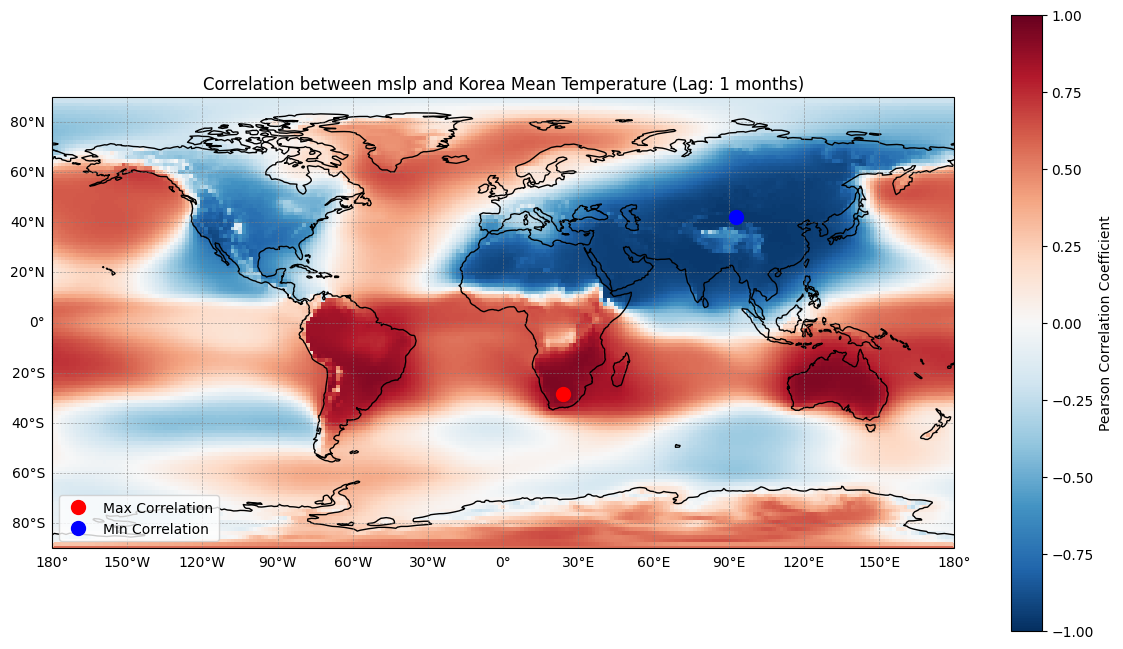


mslp과 한국 평균 온도의 상관관계 (시차: 2개월)
최대 상관계수: 0.8135 (위도 -19.5, 경도 -67.5)
최소 상관계수: -0.8980 (위도 27.0, 경도 102.0)


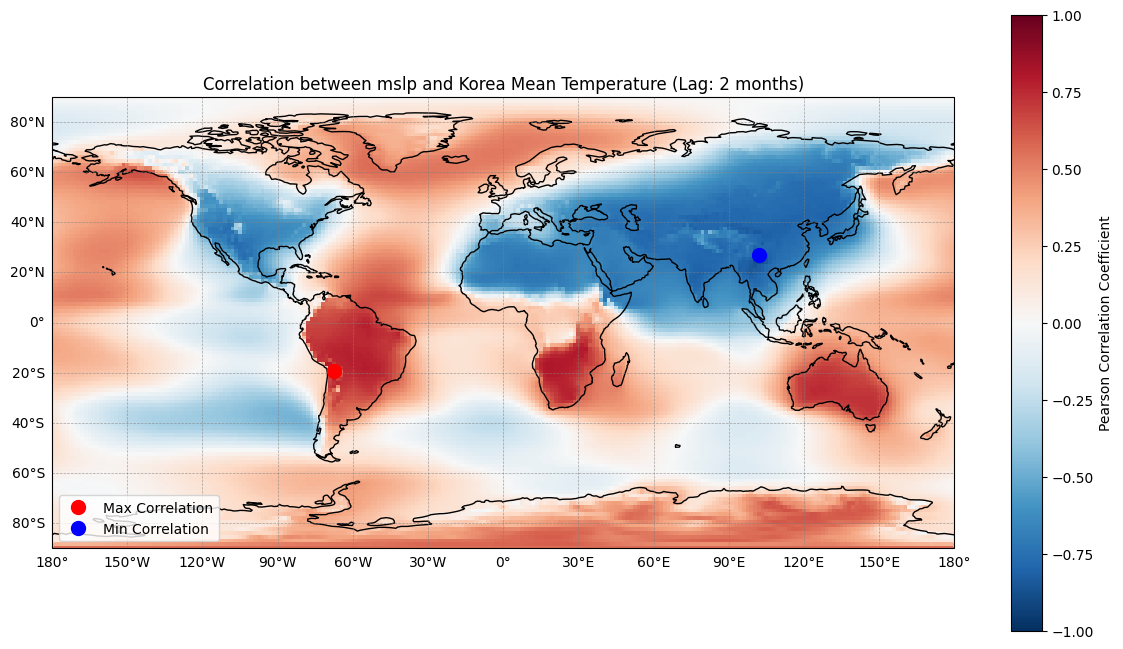


mslp과 한국 평균 온도의 상관관계 (시차: 3개월)
최대 상관계수: 0.7104 (위도 13.5, 경도 -42.0)
최소 상관계수: -0.6917 (위도 28.5, 경도 100.5)


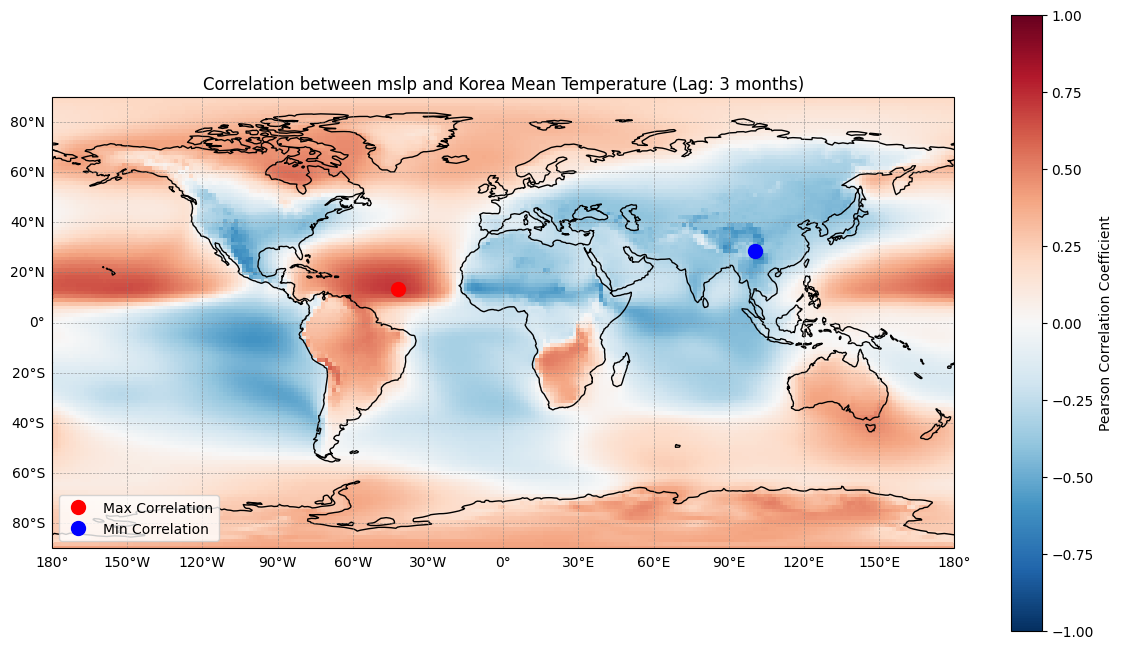


icec과 한국 평균 온도의 상관관계 (시차: 1개월)
최대 상관계수: 0.8025 (위도 -67.5, 경도 78.0)
최소 상관계수: -0.7279 (위도 76.5, 경도 -76.5)


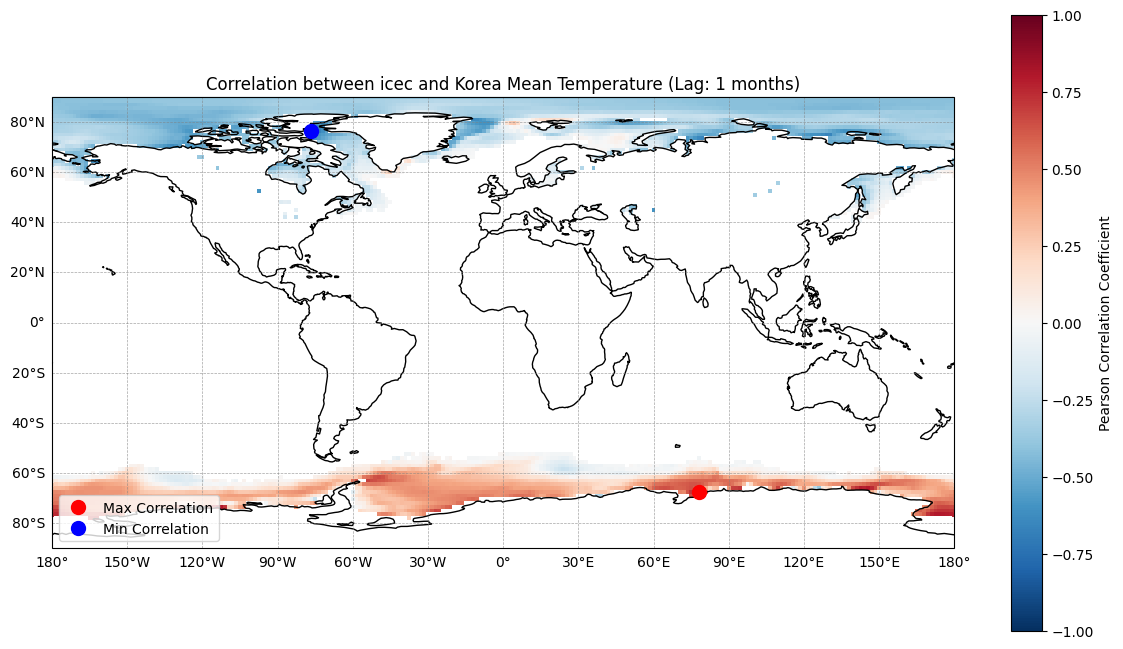


icec과 한국 평균 온도의 상관관계 (시차: 2개월)
최대 상관계수: 0.5533 (위도 -66.0, 경도 145.5)
최소 상관계수: -0.5654 (위도 -58.5, 경도 21.0)


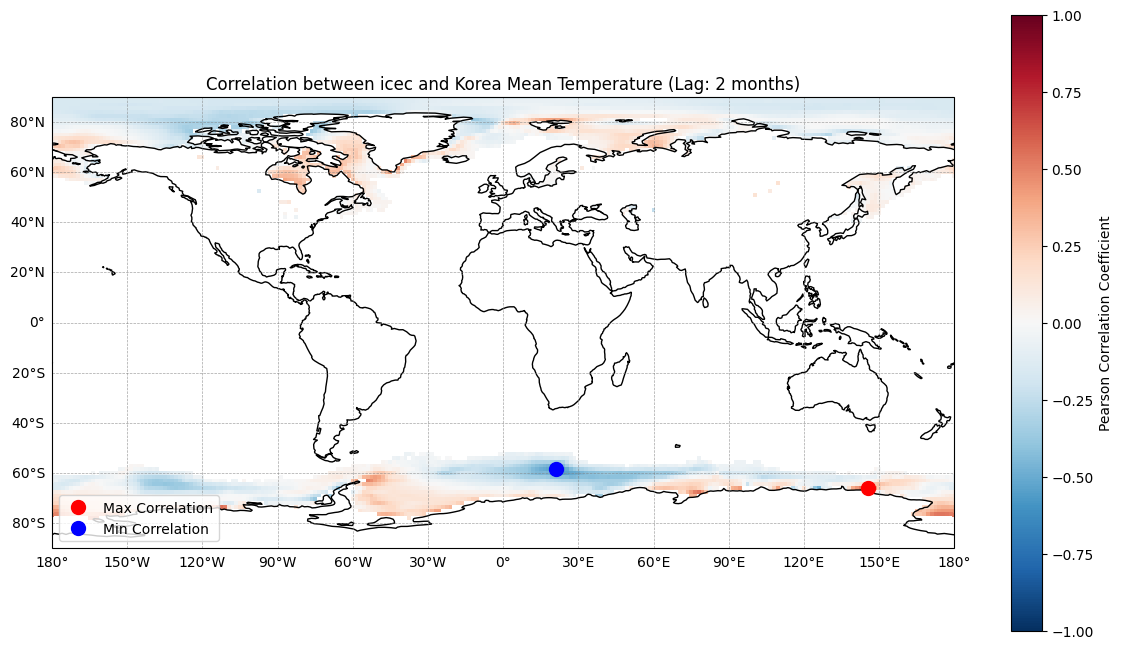


icec과 한국 평균 온도의 상관관계 (시차: 3개월)
최대 상관계수: 0.7613 (위도 57.0, 경도 -87.0)
최소 상관계수: -0.8070 (위도 -60.0, 경도 21.0)


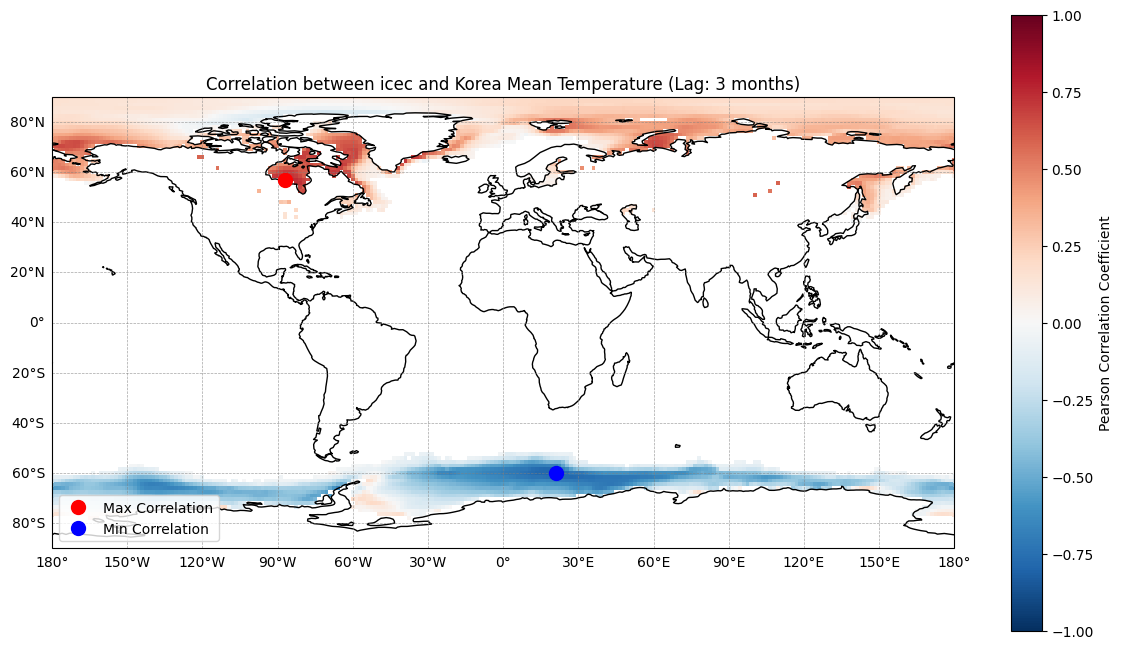


mtnlwr과 한국 평균 온도의 상관관계 (시차: 1개월)
최대 상관계수: 0.9431 (위도 -70.5, 경도 148.5)
최소 상관계수: -0.9464 (위도 63.0, 경도 136.5)


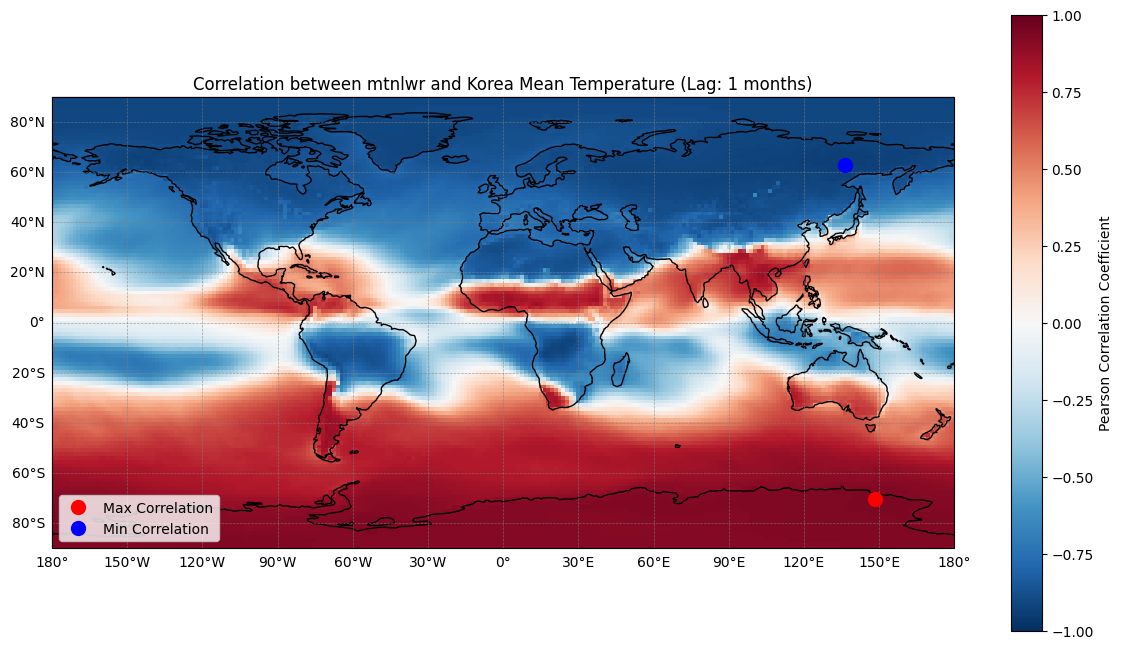


mtnlwr과 한국 평균 온도의 상관관계 (시차: 2개월)
최대 상관계수: 0.7462 (위도 24.0, 경도 112.5)
최소 상관계수: -0.7746 (위도 -13.5, 경도 3.0)


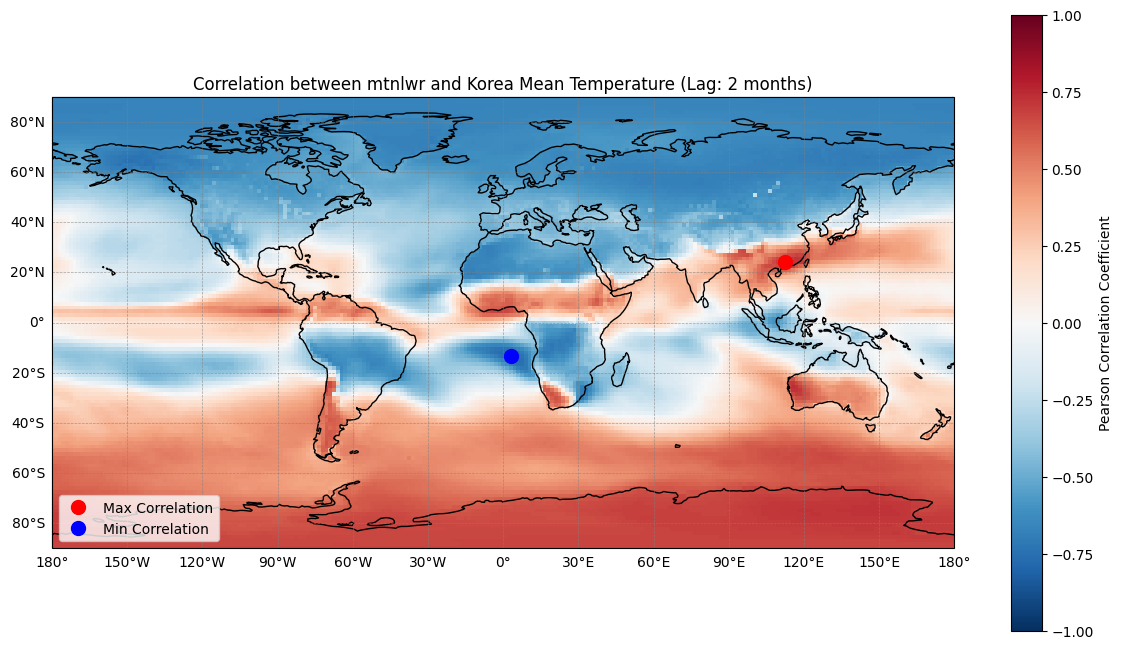


mtnlwr과 한국 평균 온도의 상관관계 (시차: 3개월)
최대 상관계수: 0.7177 (위도 3.0, 경도 -52.5)
최소 상관계수: -0.7554 (위도 -13.5, 경도 -4.5)


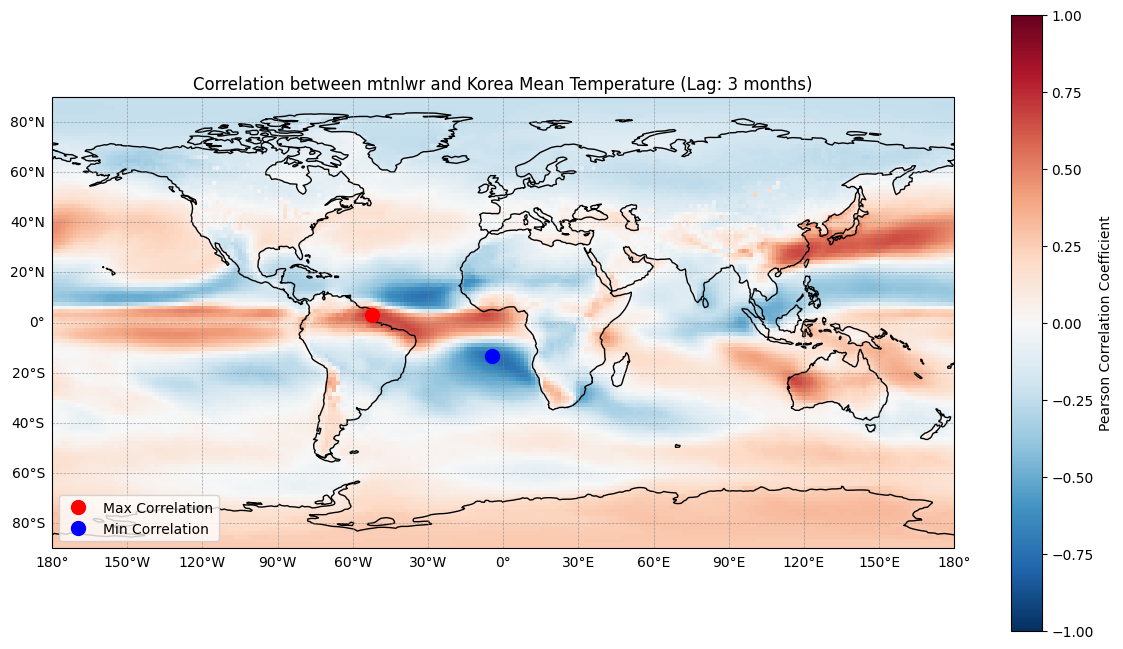


t2m과 한국 평균 온도의 상관관계 (시차: 1개월)
최대 상관계수: 0.9610 (위도 39.0, 경도 84.0)
최소 상관계수: -0.9312 (위도 -31.5, 경도 -67.5)


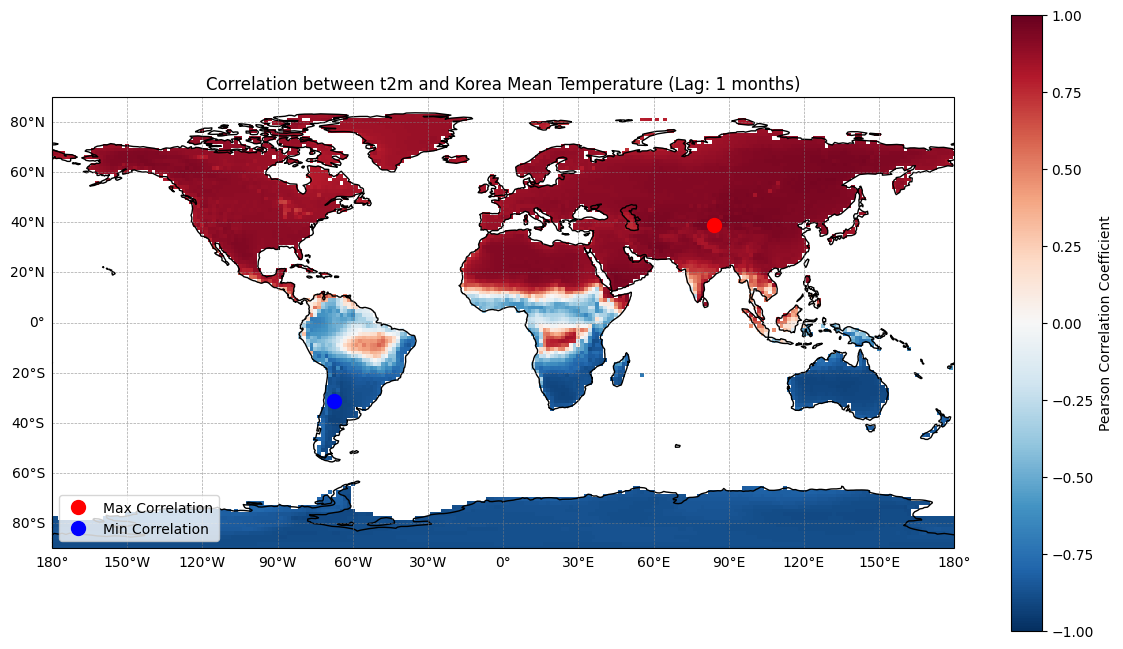


t2m과 한국 평균 온도의 상관관계 (시차: 2개월)
최대 상관계수: 0.8430 (위도 16.5, 경도 81.0)
최소 상관계수: -0.8526 (위도 -10.5, 경도 36.0)


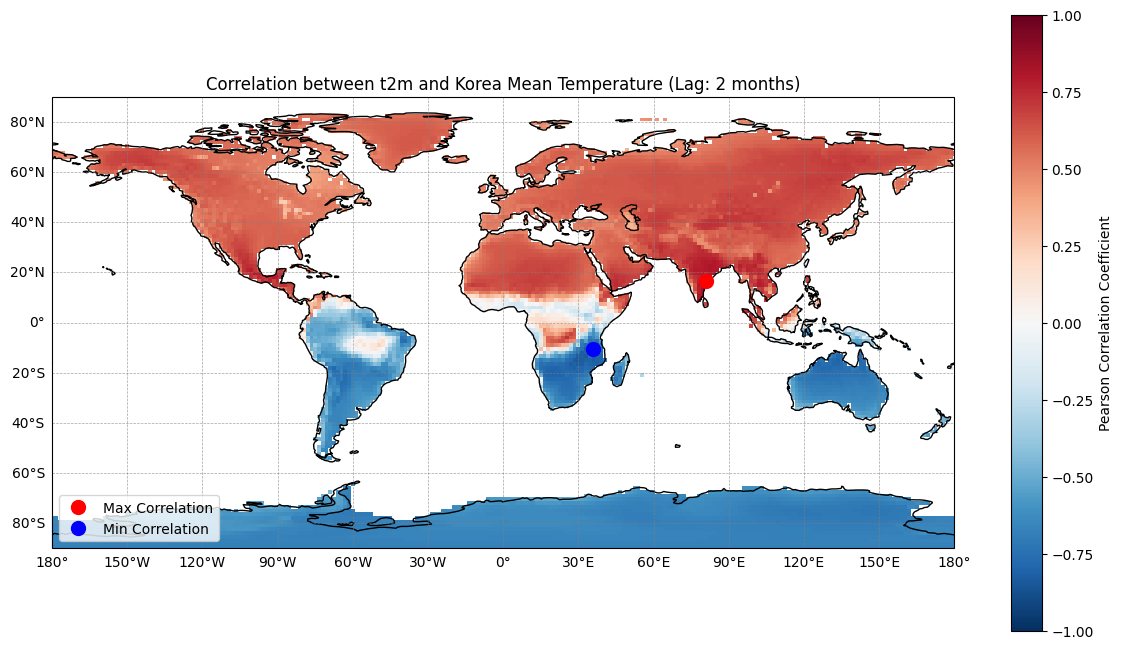


t2m과 한국 평균 온도의 상관관계 (시차: 3개월)
최대 상관계수: 0.7929 (위도 10.5, 경도 39.0)
최소 상관계수: -0.8170 (위도 0.0, 경도 -52.5)


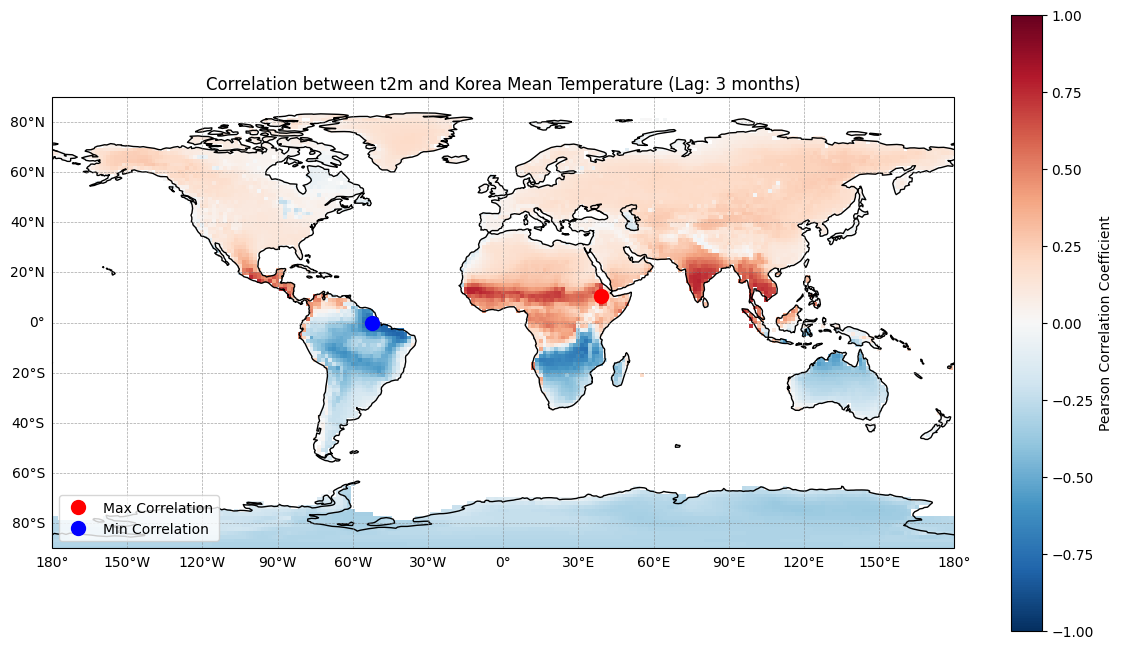


snowc과 한국 평균 온도의 상관관계 (시차: 1개월)
최대 상관계수: 0.7397 (위도 -51.0, 경도 -72.0)
최소 상관계수: -0.8567 (위도 51.0, 경도 91.5)


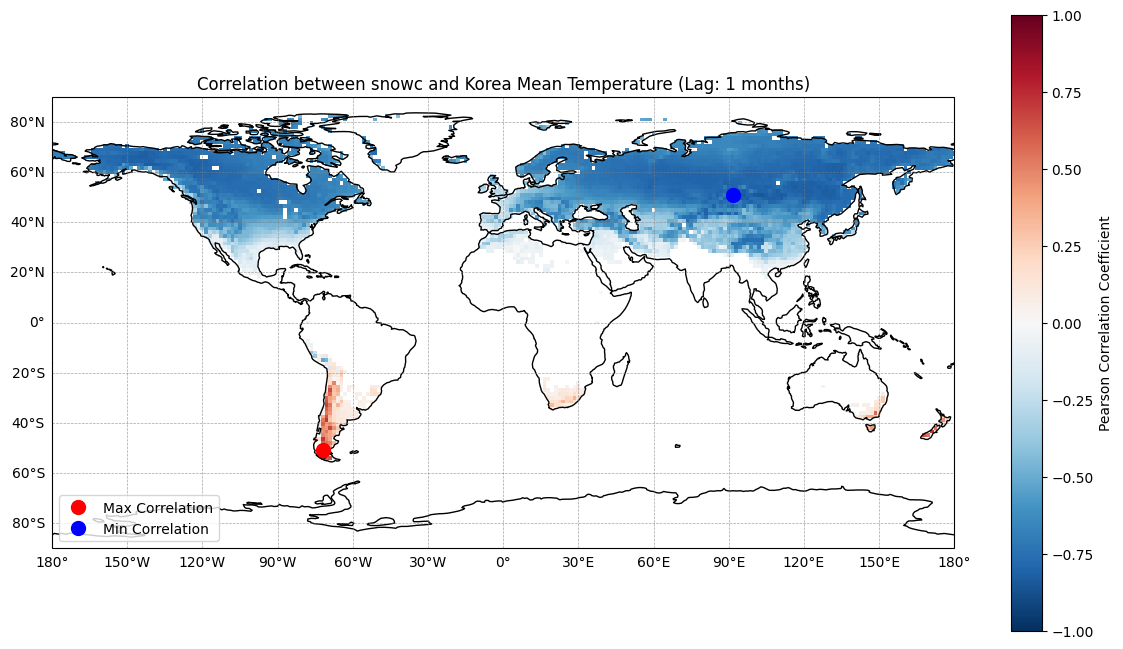


snowc과 한국 평균 온도의 상관관계 (시차: 2개월)
최대 상관계수: 0.4709 (위도 -42.0, 경도 -69.0)
최소 상관계수: -0.5766 (위도 51.0, 경도 91.5)


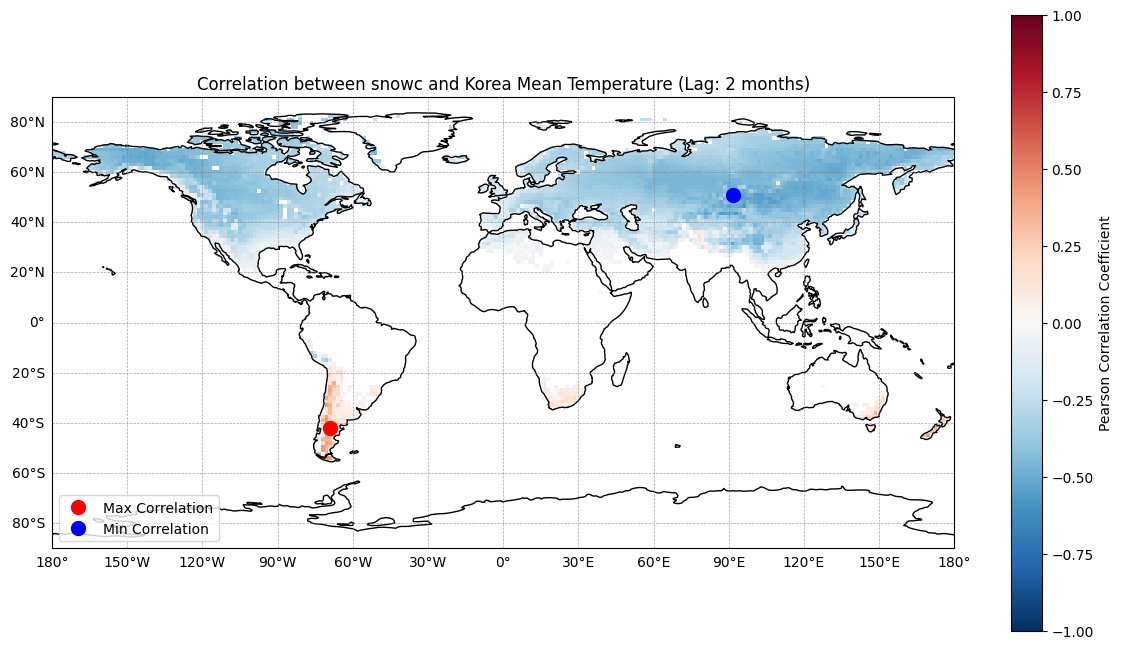


snowc과 한국 평균 온도의 상관관계 (시차: 3개월)
최대 상관계수: 0.5518 (위도 33.0, 경도 78.0)
최소 상관계수: -0.4449 (위도 -46.5, 경도 -73.5)


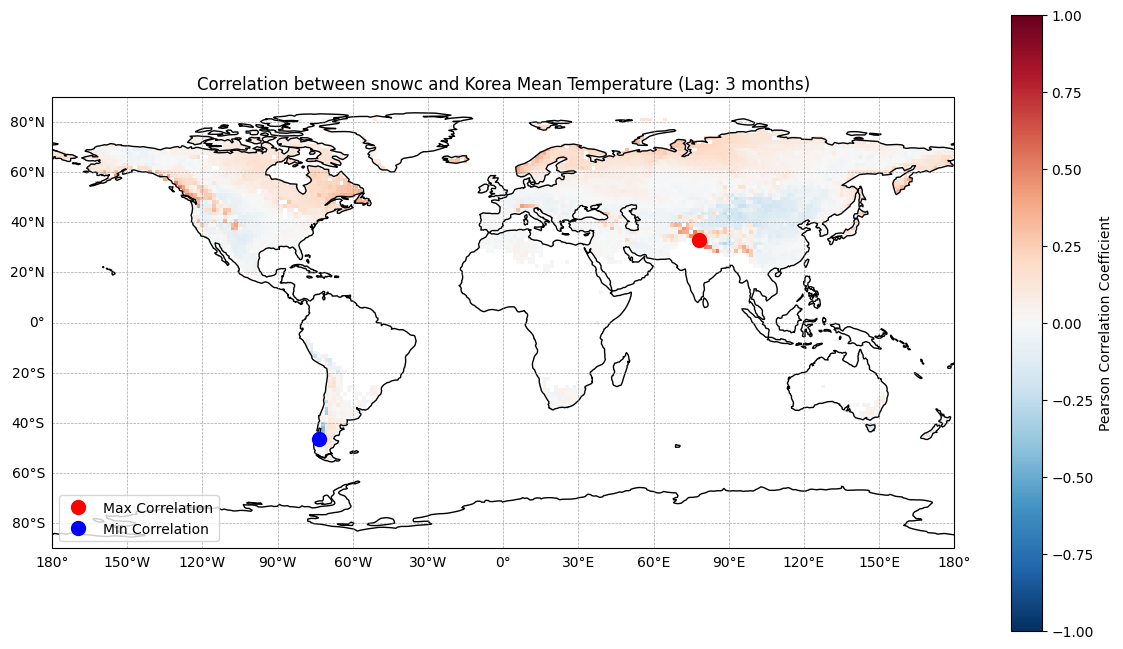

In [ ]:
# Compute and plot for nc data
for var_name in ['mslp', 'icec', 'mtnlwr', 't2m', 'snowc']:
  compute_and_plot_correlation_1(f_clm[var_name].loc[train_time], korea_mean_temp.loc[train_time], var_name)

## Combining into Dataframe

In [ ]:
f_clm_renamed = f_clm.rename({
    'valid_time': 'time',
    'latitude': 'lat',
    'longitude': 'lon'
})

f_clm = f_clm_renamed.copy()

In [ ]:
# Time Series Extraction
mslp_var = f_clm['mslp']
icec_var = f_clm['icec']
mtnlwr_var = f_clm['mtnlwr']
t2m_var = f_clm['t2m']
snowc_var = f_clm['snowc']

t2m_var_lag = t2m_var.shift(time=1)
snowc_var_lag = snowc_var.shift(time=1)

mslp_uyg = mslp_var.sel(lat=42.0, lon=93.0) #lag=1
mslp_sf = mslp_var.sel(lat=-28.5, lon=24.0) #lag=1
icec_arc = icec_var.sel(lat=-67.5, lon=78.0) #lag=1
mtnlwr_sib = mtnlwr_var.sel(lat=63.0, lon=136.5) #lag=1
mtnlwr_ant = mtnlwr_var.sel(lat=-70.5, lon=148.5) #lag=1
t2m_uyg = t2m_var.sel(lat=39.0, lon=84.0) #lag=1
t2m_cl = t2m_var.sel(lat=-31.5, lon=-67.5) #lag=1
snowc_eura = snowc_var.sel(lat=51.0, lon=91.5) #lag=1
snow_cl = snowc_var.sel(lat=-51.0, lon=-72.0) #lag=1

clmidx_df = pd.DataFrame({
    'mslp_uyg': mslp_uyg.to_series(),
    'mslp_sf': mslp_sf.to_series(),
    'icec_arc': icec_arc.to_series(),
    'mtnlwr_sib': mtnlwr_sib.to_series(),
    'mtnlwr_ant': mtnlwr_ant.to_series(),
    't2m_uyg': t2m_uyg.to_series(),
    't2m_cl': t2m_cl.to_series(),
    'snowc_cl': snow_cl.to_series(),
    'snowc_eura': snowc_eura.to_series()
})

clmidx_df

mslp_uyg      mslp_sf  icec_arc  mtnlwr_sib  mtnlwr_ant  \
time                                                                     
1979-01-01  103301.0000  101233.0000  0.207520 -153.180176 -194.258301   
1979-02-01  102269.5625  101145.4375  0.246796 -163.896240 -186.048584   
1979-03-01  101963.1875  101331.4375  0.215668 -183.544434 -171.356934   
1979-04-01  101338.4375  101518.8125  0.595154 -203.935791 -160.974854   
1979-05-01  100855.5625  102086.9375  0.626251 -210.410889 -150.391357   
...                 ...          ...       ...         ...         ...   
2023-08-01  100399.6875  102125.9375  0.849731 -241.991699 -143.358887   
2023-09-01  101111.1250  101693.5000  0.636108 -217.180176 -155.004395   
2023-10-01  101858.6875  101388.4375  0.633850 -194.837158 -165.430908   
2023-11-01  102744.8125  101218.1875  0.359344 -169.818848 -177.604004   
2023-12-01  103242.6250  101034.8750  0.048584 -154.538574 -190.499512   

               t2m_uyg      t2m_cl   snowc_cl  snowc_eura  
time                                                       
1979-01-01  267.032532  297.598938   0.001953  100.000000  
1979-02-01  273.612061  295.151123   0.023438  100.000000  
1979-03-01  280.736389  292.818420   0.115234  100.000000  
1979-04-01  290.524902  288.476074   1.091797   78.550781  
1979-05-01  294.805359  287.430359   9.828125    5.052734  
...                ...         ...        ...         ...  
2023-08-01  303.040039  287.829102  99.769531    0.000000  
2023-09-01  296.699280  289.787170  99.769531    3.109375  
2023-10-01  288.762695  293.592773  47.792969    9.566406  
2023-11-01  276.721527  296.819183   3.855469   95.492188  
2023-12-01  268.426208  299.244568   0.097656  100.000000  

[540 rows x 9 columns]

In [ ]:
ds_clm = xr.Dataset.from_dataframe(clmidx_df)
ds_clm.to_netcdf("new_clm.nc")

In [ ]:
# 시간 차원만 있는 다중 변수 Dataset을 다루기 쉬운 DataFrame으로 변환
if isinstance(f_idx, xr.Dataset) and set(f_idx.dims) == {'time'}:
    # 시간 인덱스로 사용할 값 추출
    time_index = f_idx.time.values

    # 각 변수를 DataFrame의 열로 변환
    data = {}
    for var_name in f_idx.data_vars:
        data[var_name.upper()] = f_idx[var_name].values

    # DataFrame 생성
    clm_idx_df = pd.DataFrame(data, index=time_index)

print(clm_idx_df)

              AAO  AMMSST  AMON.US.LONG     AO    EA     ESPI  GMSST  MEIV2  \
1979-01-01  0.209    1.15        -0.205 -2.233 -0.79  1.01533   0.09   0.47   
1979-02-01  0.356    2.50        -0.164 -0.697 -0.20  0.70502  -0.13   0.29   
1979-03-01  0.899    2.37        -0.241 -0.814 -0.10  0.17286   0.24  -0.05   
1979-04-01  0.678    2.16        -0.250 -1.157  0.15 -0.15151   0.23   0.21   
1979-05-01  0.724    2.42        -0.130 -0.250 -0.83 -0.09556  -0.03   0.27   
...           ...     ...           ...    ...   ...      ...    ...    ...   
2023-08-01 -0.038    2.95         0.358 -0.602 -2.35  1.00887   1.41   0.51   
2023-09-01 -1.050    5.72         0.662  0.318 -2.14  0.80097   1.86   0.68   
2023-10-01  0.535    5.51         0.483 -0.414  0.61  1.31229   1.57   0.48   
2023-11-01  0.097    4.00         0.282 -0.036  0.13 -0.79040   1.65   0.91   
2023-12-01  1.510    2.58         0.218 -0.222  0.08 -1.25044   1.61   1.13   

             NAO  NINA1.ANOM  ...   ONI  PACWARM   

In [ ]:
combined_df=pd.concat([clm_idx_df, clmidx_df], axis=1)
combined_df

AAO  AMMSST  AMON.US.LONG     AO    EA     ESPI  GMSST  MEIV2  \
1979-01-01  0.209    1.15        -0.205 -2.233 -0.79  1.01533   0.09   0.47   
1979-02-01  0.356    2.50        -0.164 -0.697 -0.20  0.70502  -0.13   0.29   
1979-03-01  0.899    2.37        -0.241 -0.814 -0.10  0.17286   0.24  -0.05   
1979-04-01  0.678    2.16        -0.250 -1.157  0.15 -0.15151   0.23   0.21   
1979-05-01  0.724    2.42        -0.130 -0.250 -0.83 -0.09556  -0.03   0.27   
...           ...     ...           ...    ...   ...      ...    ...    ...   
2023-08-01 -0.038    2.95         0.358 -0.602 -2.35  1.00887   1.41   0.51   
2023-09-01 -1.050    5.72         0.662  0.318 -2.14  0.80097   1.86   0.68   
2023-10-01  0.535    5.51         0.483 -0.414  0.61  1.31229   1.57   0.48   
2023-11-01  0.097    4.00         0.282 -0.036  0.13 -0.79040   1.65   0.91   
2023-12-01  1.510    2.58         0.218 -0.222  0.08 -1.25044   1.61   1.13   

             NAO  NINA1.ANOM  ...    WP     mslp_uyg      mslp_sf  icec_arc  \
1979-01-01 -2.12        0.16  ...  1.43  103301.0000  101233.0000  0.207520   
1979-02-01 -1.20       -0.58  ... -0.66  102269.5625  101145.4375  0.246796   
1979-03-01  0.41       -0.58  ... -0.29  101963.1875  101331.4375  0.215668   
1979-04-01 -2.01        0.15  ...  0.85  101338.4375  101518.8125  0.595154   
1979-05-01 -0.90       -0.13  ... -0.13  100855.5625  102086.9375  0.626251   
...          ...         ...  ...   ...          ...          ...       ...   
2023-08-01 -1.62        3.29  ... -0.37  100399.6875  102125.9375  0.849731   
2023-09-01 -0.28        2.42  ...  1.34  101111.1250  101693.5000  0.636108   
2023-10-01 -1.70        2.32  ... -0.83  101858.6875  101388.4375  0.633850   
2023-11-01 -0.47        2.07  ...  0.59  102744.8125  101218.1875  0.359344   
2023-12-01  1.70        1.61  ...  1.21  103242.6250  101034.8750  0.048584   

            mtnlwr_sib  mtnlwr_ant     t2m_uyg      t2m_cl   snowc_cl  \
1979-01-01 -153.180176 -194.258301  267.032532  297.598938   0.001953   
1979-02-01 -163.896240 -186.048584  273.612061  295.151123   0.023438   
1979-03-01 -183.544434 -171.356934  280.736389  292.818420   0.115234   
1979-04-01 -203.935791 -160.974854  290.524902  288.476074   1.091797   
1979-05-01 -210.410889 -150.391357  294.805359  287.430359   9.828125   
...                ...         ...         ...         ...        ...   
2023-08-01 -241.991699 -143.358887  303.040039  287.829102  99.769531   
2023-09-01 -217.180176 -155.004395  296.699280  289.787170  99.769531   
2023-10-01 -194.837158 -165.430908  288.762695  293.592773  47.792969   
2023-11-01 -169.818848 -177.604004  276.721527  296.819183   3.855469   
2023-12-01 -154.538574 -190.499512  268.426208  299.244568   0.097656   

            snowc_eura  
1979-01-01  100.000000  
1979-02-01  100.000000  
1979-03-01  100.000000  
1979-04-01   78.550781  
1979-05-01    5.052734  
...                ...  
2023-08-01    0.000000  
2023-09-01    3.109375  
2023-10-01    9.566406  
2023-11-01   95.492188  
2023-12-01  100.000000  

[540 rows x 32 columns]